<a href="https://colab.research.google.com/github/lazarovps/Data-Science/blob/main/Red_wine_quality_(classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Modelo de Machine Learning que prevê a qualidade de vinhos feito um especialista**



Para construção desse case hipotético, eu utilizei uma base de dados derivada de um estudo das propriedades físico-químicas de alguns vinhos da região do Minho, em Portugal. (dataset disponível em: https://archive.ics.uci.edu/ml/datasets/wine+quality ). Esse estudo possui 2 datasets, um de vinhos brancos e outro de vinhos vermelhos, eu estou utilizando o de vinhos vermelhos.

O dataset estudado possui aproximadamente 1600 vinhos, com 12 propriedades físico-químicas de cada um e uma nota para cada vinho, (a nota considerada no estudo foi a mediana da nota de pelo menos 3 especialistas), meu objetivo é de através da análise dessas 12 propriedades, conseguir prever qual seria a avaliação dos especialistas.

#Importação das bibliotecas necessárias

In [60]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import csv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


#configurando o diretório de trabalho

%cd /content/drive/My Drive/Python


/content/drive/My Drive/Python


In [61]:
base = pd.read_csv('winequality-red.csv')
base.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [27]:
#Verificando quantas linhas há na base de dados
base.shape

(1599, 12)

In [28]:
#A base de dados 1599 linhas e 12 coluns, que são entendidas como observações e variáveis, respectivamente. para verificar quais são, podemos visualizar as 5 primeiras linhas da base de dados
base.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


*Descrição das variáveis (não confio tanto no meu inglês assim para traduzi-las)*:



**fixed acidity:** most acids involved with wine or fixed or nonvolatile (do not evaporate readily)

**volatile acidity**: the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste

**citric acid:** found in small quantities, citric acid can add 'freshness' and flavor to wines

**residual sugar:** the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet

**chlorides:** the amount of salt in the wine

**free sulfur dioxide:** the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine

**total sulfur dioxide:** amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine

**density:** the density of water is close to that of water depending on the percent alcohol and sugar content

**pH:** describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale

**sulphates:** a wine additive which can contribute to sulfur dioxide gas (S02) levels,wich acts as an antimicrobial and antioxidant

**alcohol:** the percent alcohol content of the wine

**quality:** (score between 0 and 10)


---



In [29]:
#Algumas informações básicas das nossas variáveis:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB



A principal informação que pretendo extrair aqui é o tipo das variáveis e se há variáveis com alguma observação nula. Em relação ao tipo das variáveis, quase todas são numéricas, o que já evita uma possível transformação, caso fossem categóricas.

O segundo ponto e que mais nos auxilia aqui, é que todas as variáveis possuem 1599 linhas "non-null" o que indica que não temos valores nulos.

Serão utilizadas todas as variáveis, exceto "quality", como variáveis explicativas, ou seja, com base nessas variáveis pretende-se prever qual seria a avaliação de determinado vinho se fosse feita por um especialista. A variável explicada ( ou também conhecida como a variável alvo) será "quality".

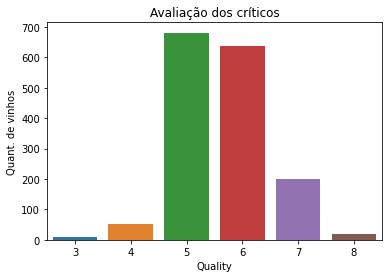

In [30]:
#É interessante analisarmos graficamente como está a distribuição da nossa variável alvo
ax = sns.countplot(x = 'quality', data = base)
plt.ylabel('Quant. de vinhos')
plt.xlabel('Quality')
plt.title('Avaliação dos críticos')
plt.show()


Vemos que nenhum dos quase 1600 vinhos foram avaliados com 9 ou 10, a maior parte ficou entre 5 e 7. Ao invés de tentarmos prever a nota de um vinho podemos querer saber apenas se um vinho seria avaliado como "bom" ou "ruim" pelos críticos, então para isso, iremos fazer uma transformação da variável alvo, onde:

Um vinho com "quality" abaixo de 7 será considerado "ruim", caso "quality" seja maior ou igual a 7, o vinho será considerado "bom". Onde o primeiro argumento da função (np.where) seria a condição, nesse caso que quality seja menor que 7, o segundo argumento é o valor atribuído à linha caso a condição seja satisfeita (a 'quality' dos vinhos ruins será substituída por 0) e o terceiro é o valor atribuído à linha caso a condição não seja satisfeita (a 'quality' dos vinhos bons será substituída por 1). Logo em seguida. verificamos a distribuição da variável alvo após a transformação.





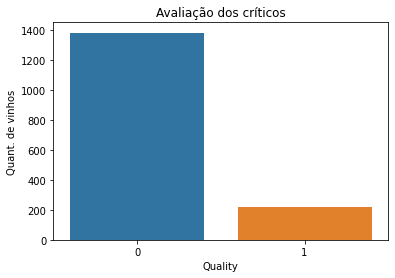

In [31]:

base['qualidade'] = np.where(base['quality']< 7, 0, 1)
ax = sns.countplot(x = 'qualidade', data = base)
plt.ylabel('Quant. de vinhos')
plt.xlabel('Quality')
plt.title('Avaliação dos críticos')
plt.show()

In [32]:
X = base.drop(['quality','qualidade'], axis = 1)
y = base['qualidade']

In [33]:
#verificando as 5 primeiras linhas da base de dados com as variáveis previsoras
X.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [34]:
#O mesmo para a variável alvo (que se tornou variável binária)
y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: qualidade, dtype: int64

In [47]:
#Iremos descartar aleatoriamente alguns exemplos de vinhos ruins
balanceador = RandomUnderSampler(random_state = 1)
x_bal, y_bal = balanceador.fit_resample(X,y)

#O argumento "random_state" é uma forma de "escolher" a aleatoriedade, é uma forma de possibilitar a replicabilidade 
#dos resultados.

In [50]:
#Verificando as linhas e colunas da nossa nova base de dados
x_bal.shape, y_bal.shape

((434, 11), (434,))

In [59]:
#Verificando a distribuição da nova variável alvo
pd.DataFrame(y_bal).value_counts()

1    217
0    217
dtype: int64

Agora, nossa base de dados possui apenas as informações de 434 vinhos (descartamos mais de 1100 !), podemos ver que a base está perfeitamente balanceada, com 217 exemplos de vinhos bons e 217 exemplos de vinhos ruins.

Para podermos simular as previsões, deveremos dividir nossa base de dados em "base de treino" e "base de teste".Na base de treino, nosso modelo aprenderá os padrões das avaliações, podendo aprender a avaliar de maneira semelhante à um crítico, se o algoritmo aprender corretamente, ele poderá prever a classificação de um vinho como bom ou ruim apenas olhando suas características (sem precisar provar rsrs),que são as variáveis previsoras (X).

Para verificarmos o poder de previsão do algoritmo, iremos simular que a base de teste é na verdade os vinhos que ainda não conhecemos a avaliação, e então poderemos prever e comparar com as reais avaliações.

Na função "train_test_split" passaremos os argumentos X e y, escolheremos também o tamanho da nossa base de dados "teste", nesse caso será de 0.3 (ou 30 %) do total dos dados e por fim "escolhemos" a aleatoriedade com qual os dados serão divididos entre treino e teste

In [40]:
#Realizando a divisão da nossa base de dados entre treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x_bal, y_bal, test_size = 0.3, random_state = 1)

Com isso, geramos 4 objetos:
x_treino e y_treino será onde o modelo vai "aprender" quais são os aspectos que influenciam na opinião de um crítico sobre determinado vinho, será com base nas informações de x_teste que o modelo fará a previsão e y_teste será a verdadeira avaliação, aqui é que iremos comparar o quão boa foi a previsão do modelo

In [41]:
#Após a divisão entre treino e teste, iremos criar o modelo ou algoritmo que irá tentar captar os padrões nas avaliações
#Importando a biblioteca necessária
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver= 'liblinear')

#O algoritmo Logistic Regression (Regressão Logística) é comumente utilizado para prever a probabilide de um evento ocorrer,
#Nesse caso, iremos utiliza-lo para classificar um evento, que no nosso caso, é se o vinho será ruim (0) ou bom (1)

#"Ensinando" o algoritmo os padrões das avaliações dos críticos
logreg.fit(x_treino,y_treino)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
#Após ensinarmos os padrões das avaliações, podemos tentar prever a classificação de novos vinhos
y_previsto = logreg.predict(x_teste)

Criamos um objeto chamado 'y_previsto' nele estão as previsões do algoritmo para os vinhos da base "x_treino", agora podemos comparar essas previsões com as reais classificações dadas pelos críticos à esses(com a base de dados "y_teste") e então saberemos o quão próximo está nosso algoritmo da avaliação de um crítico,para isso, devemos ter alguma forma de mensurar essa proximidade, que nesse caso será pela métrica conhecida como acurácia. 
A acurácia é entendida como a quantidade de previsões corretas dividida pela quantidade total de previsões, por exemplo, se fizermos 100 previsões e acertamos 70, nossa acurácia será de 70/100, ou, 70%, então, nosso objetivo nesse caso é ter uma boa capacidade de previsão, que será entendida como obter uma acurácia o mais próxima possível de 1.

In [43]:
#importando uma biblioteca para verificar a acurácia do algoritmo
from sklearn.metrics import accuracy_score
accuracy_score(y_previsto, y_teste)

0.8549618320610687

Com o resultado, vemos que o nosso algoritmo acertou 85% das previsões que ele fez, o que pode ser considerado um valor muito bom, considerando que usamos um dos mais simples algoritmo de aprendizado de máquina.

Podemos criar exemplos e ver qual seria a previsão do algoritmo, para isso, seria necessário ter todas as caracterísitcas que nosso algoritmo utilizou para aprender a classificar.(tecnicamente não precisaria de todas, mas ignoremos isso).

In [44]:
#Consideremos o exemplo (valores atribuídos aleatoriamente):
vinhos = pd.DataFrame(np.array([[8,0.35,0.4,3,0.09,13,29,0.99230,3.3,0.7,11.7],
                            [9.5,0.44,0.23,4,0.16,19,45,0.98700,4.1,0.54,9.2]]), 
                      columns = X.columns, index = ['quintas_do_morgado','vinho_quentinho'])

vinhos

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quintas_do_morgado,8.0,0.35,0.40,3.0,0.09,13.0,29.0,0.9923,3.3,0.70,11.7
vinho_quentinho,9.5,0.44,0.23,4.0,0.16,19.0,45.0,0.9870,4.1,0.54,9.2


In [45]:
#Agora podemos prever qual seria a classificação dos críticos para cada um dos vinhos que acabamos de criar
logreg.predict(vinhos)

array([1, 0])

O resultado mostra que o primeiro vinho da base de dados, no nosso caso o vinho 'quintas_do_morgado' seria classificado como bom (valor = 1) pelos críticos, enquanto que o 'vinho_quentinho' seria tido com ruim (valor = 0), lembrando que, é possível obter uma acurácia maior com algoritmos mais complexos. Pretendo um dia refazer esse projeto com um algoritmo mais robusto, a fim de obter maior acurácia.